In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import haversine_distances
from math import radians
import folium
import math
import matplotlib.pyplot as plt
from folium import plugins
from folium.plugins import HeatMap
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import io
from PIL import Image
%matplotlib inline

In [2]:
la = pd.read_csv("la_2019.csv", parse_dates=["start_time","end_time"], low_memory=False)


In [3]:
# Add duration
la["duration"] = (la["end_time"] - la["start_time"]).astype("timedelta64[m]")
la["user_type"].size


290342

In [4]:
# remove data with same start and end station, that are shorter or equal to one minutes
print(la[((la["start_station_name"] == la["end_station_name"]) & (la["duration"] <= 1.0))].size)
filtered_data = la[ ~((la["start_station_name"] == la["end_station_name"]) & (la["duration"] <= 1.0)) ]


53325


In [5]:
# new data set with station information (locations)
# https://gbfs.bcycle.com/bcycle_lametro/station_information.json
coordinates = pd.read_csv("station_information.csv")
# drop unnecessary columns
coordinates = coordinates.drop(columns=['ttl', 'data__stations__rental_uris__ios','data__stations__rental_uris__android','version','last_updated'])
coordinates.head(3)


,data__stations__lon,data__stations__lat,data__stations___bcycle_station_type,data__stations__region_id,data__stations__address,data__stations__name,data__stations__station_id
0,-118.25854,34.04850,Kiosk and Station,bcycle_lametro_region_1,Reinstalled 6/15,7th & Flower,bcycle_lametro_3005
1,-118.25667,34.04554,Kiosk and Station,bcycle_lametro_region_1,729 S Olive Street,Olive & 8th,bcycle_lametro_3006
2,-118.25459,34.05048,Kiosk and Station,bcycle_lametro_region_1,557 S 5th Street,5th & Grand,bcycle_lametro_3007


In [6]:
# adding coordinates to stations
coordinates["ziped_coords_start"] = list(zip(coordinates["data__stations__lat"],coordinates["data__stations__lon"]))
la = la.merge(coordinates["ziped_coords_start"].to_frame(),how = "left",left_on=la["start_station_name"],right_on=coordinates["data__stations__name"])
la = la.drop(columns=["key_0"])
# dropping stations without location data
la = la.dropna(axis=0)
la.head(3)

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,duration,ziped_coords_start
0,2019-01-01 00:07:00,2019-01-01 00:14:00,3046,3051,06468,Walk-up,2nd & Hill,7th & Broadway,7.0,"(34.05287, -118.24749)"
1,2019-01-01 00:08:00,2019-01-01 00:14:00,3046,3051,12311,Walk-up,2nd & Hill,7th & Broadway,6.0,"(34.05287, -118.24749)"
2,2019-01-01 00:18:00,2019-01-01 00:50:00,3030,3075,05992,Walk-up,Main & 1st,Broadway & 9th,32.0,"(34.05194, -118.24353)"


In [7]:
coordinates["ziped_coords_end"] = list(zip(coordinates["data__stations__lat"],coordinates["data__stations__lon"]))
la = la.merge(coordinates["ziped_coords_end"].to_frame(),how = "left",left_on=la["end_station_name"],right_on=coordinates["data__stations__name"])
la = la.drop(columns=["key_0"])

la = la.dropna(axis=0)
la.head(3)

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,duration,ziped_coords_start,ziped_coords_end
2,2019-01-01 00:18:00,2019-01-01 00:50:00,3030,3075,05992,Walk-up,Main & 1st,Broadway & 9th,32.0,"(34.05194, -118.24353)","(34.04211, -118.25619)"
3,2019-01-01 00:20:00,2019-01-01 00:50:00,3030,3075,05860,Walk-up,Main & 1st,Broadway & 9th,30.0,"(34.05194, -118.24353)","(34.04211, -118.25619)"
4,2019-01-01 00:22:00,2019-01-01 00:50:00,3030,3075,06006,Walk-up,Main & 1st,Broadway & 9th,28.0,"(34.05194, -118.24353)","(34.04211, -118.25619)"


In [8]:
# distance 
# x and y coordinate of start and end point in lat1,lat2,lon1,lon2

la["lat1"], la["lon1"] = list(zip(*la["ziped_coords_start"]))
la["lat2"], la["lon2"] = list(zip(*la["ziped_coords_end"]))
lat1 = la["lat1"].tolist()
lat2 = la["lat2"].tolist()
lon1 = la["lon1"].tolist()
lon2 = la["lon2"].tolist()
listsize = len(lon2)

In [9]:
# method to calculate distance

distance = []
radius = 6371  # km

for n in range(listsize):
     
    dlat = math.radians(lat2[n] - lat1[n])
    dlon = math.radians(lon2[n] - lon1[n])
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1[n])) * math.cos(math.radians(lat2[n])) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c
    distance.append(round(d,2))
distance = list(distance)

In [10]:
la.insert(loc=0, column='distance', value=distance)

In [11]:
# City centre for distance calculation
la_centre = [34.052235, -118.243683]
la_centre_rad = [radians(_) for _ in la_centre]

la["start_dist_centre"] = la.apply(lambda x: (haversine_distances([[radians(_) for _ in la_centre], [radians(_) for _ in [x.lat1,x.lon1]]]))[0][1] * 6371000/1000, axis = 1)
la["end_dist_centre"] = la.apply(lambda x: (haversine_distances([[radians(_) for _ in la_centre], [radians(_) for _ in [x.lat2,x.lon2]]]))[0][1] * 6371000/1000, axis = 1)


In [12]:
# selecting distance, duration, start_dist_centre, end_dist_centre as attributes for clustering

la_cleaned = la
la_cleaned = la_cleaned.drop(columns=["start_time","end_time","start_station_id","end_station_id","bike_id","start_station_name","end_station_name","ziped_coords_start", "ziped_coords_end", "lat1", "lat2", "lon1", "lon2"])

X = la_cleaned.drop("user_type", axis=1)
y = la_cleaned["user_type"]
X.head()

,distance,duration,start_dist_centre,end_dist_centre
2,1.6,32.0,0.035703,1.611013
3,1.6,30.0,0.035703,1.611013
4,1.6,28.0,0.035703,1.611013
5,1.6,28.0,0.035703,1.611013
6,1.6,27.0,0.035703,1.611013


In [13]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled_df.head()

,distance,duration,start_dist_centre,end_dist_centre
2,0.416712,0.042198,-0.603121,-0.349581
3,0.416712,0.026656,-0.603121,-0.349581
4,0.416712,0.011114,-0.603121,-0.349581
5,0.416712,0.011114,-0.603121,-0.349581
6,0.416712,0.003343,-0.603121,-0.349581


In [14]:
# Add usertype to scaled data
la_scaled = X_scaled_df
la_scaled["user_type"]=la_cleaned["user_type"]

In [15]:
# counting which station is used how often
start_count = la['start_station_name'].value_counts()
end_count = la['end_station_name'].value_counts()
start_count_coord = la['ziped_coords_start'].value_counts()

In [16]:
# new dataframe 
station = start_count.to_frame().rename(columns = {'start_station_name': 'start_count'})
station['end_count'] = end_count
station['sum'] = station['start_count'] + station['end_count']
station['station_name'] = station.index
station['ziped_coords'] = start_count_coord.index
station["lat"], station["lon"] = list(zip(*station["ziped_coords"]))
station = station.sort_values(by='sum', ascending=False)
station.reset_index(drop=True, inplace=True) 
station

,start_count,end_count,sum,station_name,ziped_coords,lat,lon
0,13015,13893,26908,7th & Flower,"(34.0485, -118.25854)",34.04850,-118.25854
1,12387,10657,23044,Main & 1st,"(34.05194, -118.24353)",34.05194,-118.24353
2,10535,11699,22234,Union Station West Portal,"(34.05661, -118.23721)",34.05661,-118.23721
3,8094,8603,16697,7th & Spring,"(34.0447, -118.25244)",34.04470,-118.25244
4,6191,7101,13292,Ocean Front Walk & Navy,"(33.99556, -118.48155)",33.99556,-118.48155
...,...,...,...,...,...,...,...
158,27,27,54,Sunset Triangle Plaza,"(34.09028, -118.27719)",34.09028,-118.27719
159,22,20,42,Rose & Overland,"(34.02765, -118.41356)",34.02765,-118.41356
160,17,17,34,Playa Vista Library,"(33.97024, -118.42607)",33.97024,-118.42607
161,12,12,24,Santa Monica & Virgil,"(34.09097, -118.28625)",34.09097,-118.28625


In [17]:
long_map = folium.Map(location=(34.052235, -118.243683),tiles='OpenStreetMap',zoom_start=11, control_scale=True, max_zoom=20)

# drawing maps and dots
for index, row in station.iterrows():
    folium.CircleMarker(radius=np.power(np.log(row["sum"])/3,1.5), location=row["ziped_coords"], popup=row["station_name"], color="red", fill_color="red",weight=2).add_to(long_map)

long_map

C:\Users\Lena\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Text(0.5, 1.0, 'Elbow Curve')

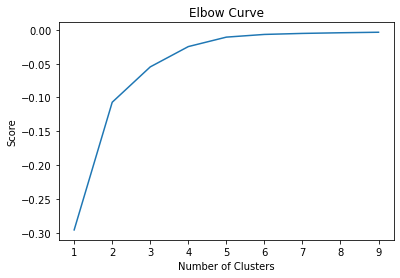

In [18]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = station[['lat']]
X_axis = station[['lon']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')

In [19]:
X=station.loc[:,['sum','lat','lon']]
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(X[X.columns[1:3]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[1:3]]) # Labels of each point
X.head(5)

,sum,lat,lon,cluster_label
0,26908,34.04850,-118.25854,0
1,23044,34.05194,-118.24353,0
2,22234,34.05661,-118.23721,0
3,16697,34.04470,-118.25244,0
4,13292,33.99556,-118.48155,1


In [20]:
long_map = folium.Map(location=(34.052235, -118.243683),tiles='OpenStreetMap',zoom_start=11, control_scale=True, max_zoom=20)

# drawing maps and dots
for index, row in station.iterrows():
    if (X['cluster_label'].iloc[index]==0):
        color = "blue"
    elif (X['cluster_label'].iloc[index]==1):
        color = "orange"
    elif (X['cluster_label'].iloc[index]==2):
        color = "red"
    folium.CircleMarker(radius=np.power(np.log(row["sum"])/3,1.5), location=row["ziped_coords"], popup=row["station_name"], color=color, fill_color=color,weight=2).add_to(long_map) 
    
long_map